<a href="https://colab.research.google.com/github/banno-0720/learning_TensorFlow/blob/main/VAE_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
len(dataset)

70000

In [5]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [6]:
train_dataset = (
    dataset
    .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

## Sampling

In [8]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

## Encoder

In [9]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [10]:
latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Overall VAE Model

In [11]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input,output,name="vae")
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vae_input (InputLayer)               │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
for i in range(3):
  print(vae.layers[i])

<InputLayer name=vae_input, built=True>
<Functional name=encoder, built=True>
<Functional name=decoder, built=True>


# Training

In [13]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 20

In [14]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)), axis = 1))

  return loss_rec+loss_reg

In [15]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives,vae.trainable_weights))
  return loss

In [16]:
def neuralearn(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is:', loss)
  print('Training Complete!')

In [17]:
neuralearn(EPOCHS)

Training starts for epoch number 1
Training Loss is: tf.Tensor(195.90369, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is: tf.Tensor(183.41487, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is: tf.Tensor(171.30899, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is: tf.Tensor(156.93988, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is: tf.Tensor(169.21922, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is: tf.Tensor(161.10284, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is: tf.Tensor(152.54895, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is: tf.Tensor(154.06264, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is: tf.Tensor(144.98672, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is: tf.Tensor(147.72472, shape=(), dtype=float32)
Training 

## Overriding train_step method

In [28]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [29]:
model=VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=20,batch_size=128,)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 151.5137
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 151.2965
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 151.1788
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 150.9529
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 150.8025
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 150.6630
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 150.3686
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 150.2240
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 150.1931
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 150.3318
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 149.8779
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 149.7956
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 149.7065
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 149.5541
Epoch 15/20
547/547 ━━━━━━━

# Testing

In [30]:
scale = 1
n = 16

In [31]:
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

In [32]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

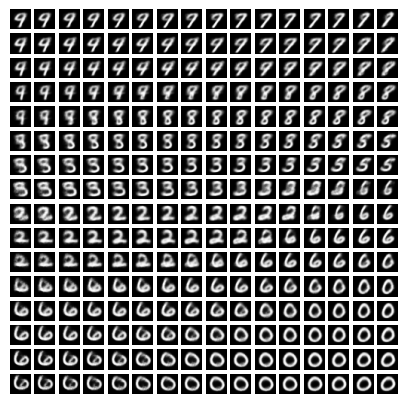

In [33]:
plt.figure(figsize=(5,5))
k = 0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n,n,k+1)

    input = tf.constant([[i,j]])
    out=vae.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis("off")
    k += 1

In [34]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(28, 28)


In [35]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


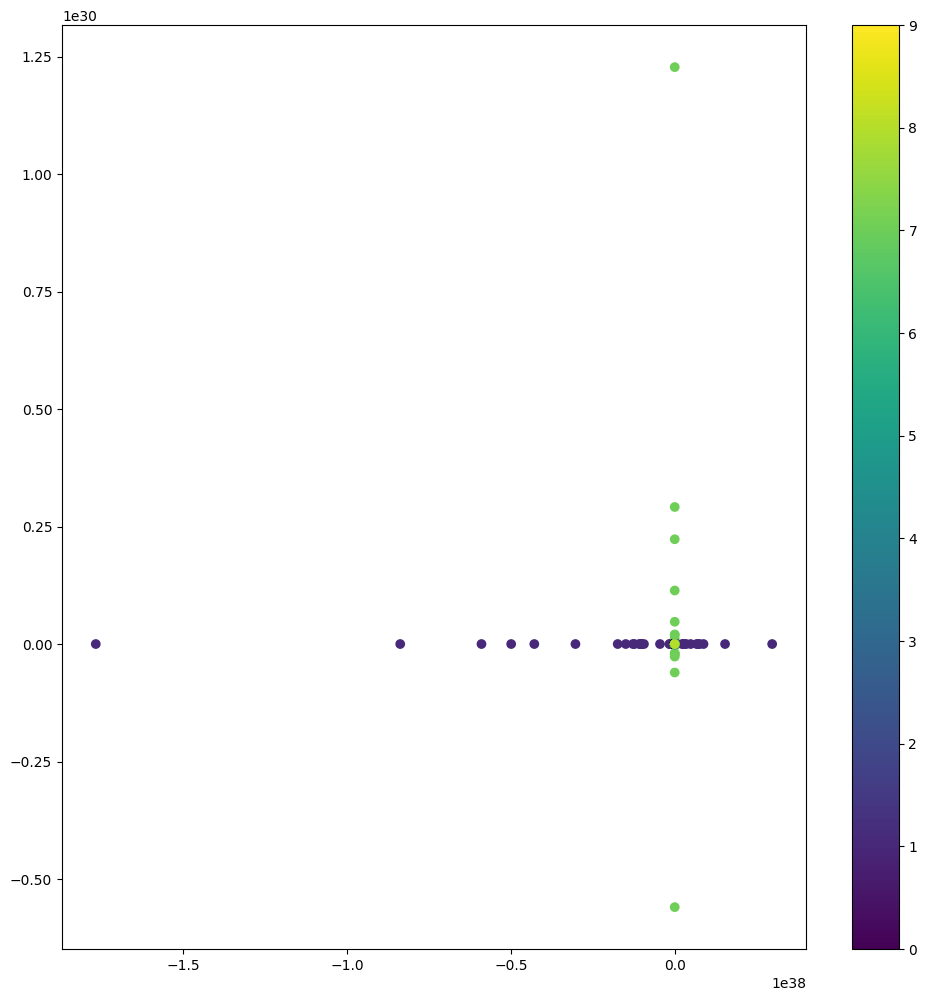

In [36]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()